# **Asphalt Pavement Condition Classification**

In [6]:
import os
import io
import itertools
import numpy as np
import scipy.io
import joblib
import pandas as pd
from tabulate import tabulate
from scipy.stats import skew, kurtosis
import random
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support, precision_recall_curve, roc_curve, classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, label_binarize
from sklearn.utils import shuffle
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, Flatten, Dropout, Dense, BatchNormalization, Concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ReduceLROnPlateau
import keras_tuner as kt
from qkeras import QConv1D, QDense
from qkeras.quantizers import quantized_bits
from datetime import datetime


epoch = 100
trial = 200

# Extract statistical features

In [7]:
def extract_features(X_raw, threshold=0.05, min_quiet_length=10):
    features = []
    for x in X_raw:
        # Duration until quiet
        quiet_idx = -1
        for i in range(len(x) - min_quiet_length + 1):
            if np.all(np.abs(x[i:i+min_quiet_length]) < threshold):
                quiet_idx = i
                break
        duration_until_quiet = quiet_idx if quiet_idx >= 0 else len(x)

        feats = [
            np.mean(x),
            np.std(x),
            np.min(x),
            np.max(x),
            np.percentile(x, 25),
            np.percentile(x, 50),
            np.percentile(x, 75),
            skew(x),
            kurtosis(x),
            np.sum(np.square(x)),  # Energy
            np.sum(np.diff(np.sign(x)) != 0),  # Zero-crossings
            duration_until_quiet
        ]
        features.append(feats)
    return np.array(features)


# Dataset Preparation

In [8]:
def load_ts_file(filepath):
    #Load time series data from .ts file
    with open(filepath, 'r') as file:
        lines = file.readlines()
        
    # Skip header lines
    data_start_idx = 0
    for i, line in enumerate(lines):
        if line.strip() == '@data':
            data_start_idx = i + 1
            break
    
    X = []
    y = []
    
    label_map = {
        'flexible' : 0,
        'cobblestone' : 1,     #label_map is a dictionary that maps string labels to integer values.
        'dirt' : 2}
    
    # Parse data lines
    for line in lines[data_start_idx:]:
        try:
            # Split line into data and label
            parts = line.strip().split(',')
            
            # Convert time series data to float
            values = [float(val) for val in parts[:-1]]
            X.append(np.array(values, dtype=np.float32))
            
            # Parse label
            label_str = parts[-1].strip().split(':')[-1].lower()
            if label_str in label_map:
                label = label_map[label_str]
                y.append(label)
            else: 
                print(f"Unknown label found: {label_str}")
                continue

        except Exception as e:
            print(f"Error parsing line: {line}")
            print(f"Error: {e}")
            continue
    
    X = np.array(X)
    y = np.array(y, dtype=np.int32)
    
    print(f"File {filepath}:")
    print(f"Number of samples: {len(X)}")
    print(f"Unique labels: {np.unique(y)}")
    print(f"Label distribution: {np.bincount(y)}\n")
    
    return X, y

# Data augmentation function

In [9]:
def augment_classes(
    X, y,
    jitter_strength=0.01,          
    scale_range=(0.99, 1.01),       
    time_warp_prob=0.01,             
    magnitude_warp_prob=0.01,        
    min_samples=500,                
    seed=42
):
    np.random.seed(seed)
    X_augmented = []
    y_augmented = []

    class_counts = dict(zip(*np.unique(y, return_counts=True)))

    for class_label, count in class_counts.items():
        if count >= min_samples:
            continue

        needed = min_samples - count
        class_indices = np.where(y == class_label)[0]

        for _ in range(needed):
            idx = np.random.choice(class_indices)
            x_orig = X[idx].copy()

            # Jittering 
            x_aug = x_orig + np.random.normal(0.0, jitter_strength, size=x_orig.shape)

            # Scaling
            scaling_factor = np.random.uniform(*scale_range)
            x_aug *= scaling_factor

            # Time Warping
            if np.random.rand() < time_warp_prob:
                warp_factor = np.random.uniform(0.8, 1.2)
                new_len = int(len(x_aug) * warp_factor)
                x_aug = np.interp(
                    np.linspace(0, len(x_aug)-1, num=len(x_aug)),
                    np.linspace(0, len(x_aug)-1, num=new_len),
                    np.interp(np.arange(new_len), np.linspace(0, new_len-1, len(x_aug)), x_aug)
                )

            # Magnitude Warping
            if np.random.rand() < magnitude_warp_prob:
                steps = np.linspace(0, len(x_aug), num=6, dtype=int)
                warping = np.random.normal(1.0, 0.1, size=5)
                for j in range(len(warping)):
                    x_aug[steps[j]:steps[j+1]] *= warping[j]

            # Ensure same length after interpolation
            x_aug = np.interp(np.linspace(0, len(x_aug) - 1, len(x_orig)), np.arange(len(x_aug)), x_aug)

            X_augmented.append(x_aug)
            y_augmented.append(class_label)

    # Append new samples
    if X_augmented:
        X_total = np.concatenate([X, np.array(X_augmented)], axis=0)
        y_total = np.concatenate([y, np.array(y_augmented)], axis=0)
    else:
        X_total, y_total = X, y

    return X_total, y_total


In [10]:
class AsphaltDataLoader:
    def __init__(self, data_dir='AsphaltPavementType', seed=42):
        self.data_dir = data_dir
        self.seed = seed
        self.scaler = StandardScaler()
        self.feature_scaler = StandardScaler()
        
    def load_dataset(self, batch_size=32, val_split=0.15):
        train_file = os.path.join(self.data_dir, 'AsphaltPavementType_eq_TRAIN.ts')
        X_train_raw, y_train = load_ts_file(train_file)

        X_train_raw, y_train = augment_classes(X_train_raw, y_train)

        print("New train distribution:", np.bincount(y_train))
        plt.figure(figsize=(10, 4))
        plt.plot(X_train_raw[0], label='Original cobblestone')
        plt.plot(X_train_raw[-1], label='Augmented sample', linestyle='--')
        plt.title("Augmentation Check - Cobblestone")
        plt.xlabel("Timestep")
        plt.ylabel("Value")
        plt.legend()
        plt.grid(True)
        plt.show()

        
        test_file = os.path.join(self.data_dir, 'AsphaltPavementType_eq_TEST.ts')
        X_test_raw, y_test = load_ts_file(test_file)
        
        # Extract features from raw time series data
        features_train = extract_features(X_train_raw)
        features_test = extract_features(X_test_raw)

        
        # Print dataset statistics just for verification
        print("Training samples:", len(X_train_raw))
        print("Test samples:", len(X_test_raw))
        print("Unique classes in training:", np.unique(y_train))
        print("Class distribution in training:", np.bincount(y_train))
        
        # Scale the train and features
        X_train = self.scaler.fit_transform(X_train_raw)
        X_test = self.scaler.transform(X_test_raw)
        
        features_train = self.feature_scaler.fit_transform(features_train)
        features_test = self.feature_scaler.transform(features_test)

        # Split training data into train and validation
        train_size = int(len(X_train) * (1 - val_split))
        
        # Shuffle indices
        indices = np.arange(len(X_train))
        np.random.seed(self.seed)
        np.random.shuffle(indices)
        
        # Create train and validation sets
        X_train_final = X_train[indices[:train_size]]
        y_train_final = y_train[indices[:train_size]]
        X_val = X_train[indices[train_size:]]
        y_val = y_train[indices[train_size:]]

        features_train_final = features_train[indices[:train_size]]
        features_val = features_train[indices[train_size:]]

        # One-hot encode AFTER train/val split
        self.y_train_raw = y_train_final.copy()
        y_train_final = to_categorical(y_train_final, num_classes=3)
        y_val = to_categorical(y_val, num_classes=3)
        y_test = to_categorical(y_test, num_classes=3)

        
        # Reshape data to add channel dimension
        X_train_final = X_train_final.reshape(-1, X_train_final.shape[1], 1)
        X_val = X_val.reshape(-1, X_val.shape[1], 1)
        X_test = X_test.reshape(-1, X_test.shape[1], 1)


        # Create TensorFlow datasets
        train_ds = tf.data.Dataset.from_tensor_slices(((X_train_final, features_train_final), y_train_final))\
        .shuffle(buffer_size=10000)\
        .batch(batch_size)\
        .prefetch(tf.data.AUTOTUNE)

        val_ds = tf.data.Dataset.from_tensor_slices(((X_val, features_val), y_val))\
        .batch(batch_size)\
        .prefetch(tf.data.AUTOTUNE)

        test_ds = tf.data.Dataset.from_tensor_slices(((X_test, features_test), y_test))\
        .batch(batch_size)\
        .prefetch(tf.data.AUTOTUNE)

        
        sequence_length = X_train_final.shape[1]
        
        return train_ds, val_ds, test_ds, sequence_length

In [11]:
def load_asphalt_dataset(batch_size=128, seed=42):
    loader = AsphaltDataLoader(seed=seed)
    return loader.load_dataset(batch_size=batch_size)

# Finally load the dataset

File AsphaltPavementType/AsphaltPavementType_eq_TRAIN.ts:
Number of samples: 1055
Unique labels: [0 1 2]
Label distribution: [408 263 384]

New train distribution: [500 500 500]


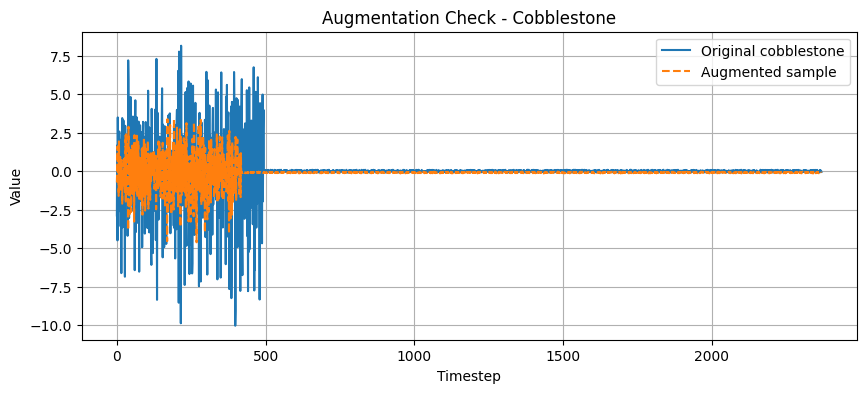

File AsphaltPavementType/AsphaltPavementType_eq_TEST.ts:
Number of samples: 1056
Unique labels: [0 1 2]
Label distribution: [408 264 384]

Training samples: 1500
Test samples: 1056
Unique classes in training: [0 1 2]
Class distribution in training: [500 500 500]


2025-07-08 11:15:04.757084: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2025-07-08 11:15:04.758752: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2025-07-08 11:15:04.759008: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (WIN-UME7Q8ASDN0): /proc/driver/nvidia/version does not exist
2025-07-08 11:15:04.774260: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [12]:
train_ds, val_ds, test_ds, sequence_length = load_asphalt_dataset(batch_size=128)

# Data Visualization

File AsphaltPavementType/AsphaltPavementType_eq_TRAIN.ts:
Number of samples: 1055
Unique labels: [0 1 2]
Label distribution: [408 263 384]



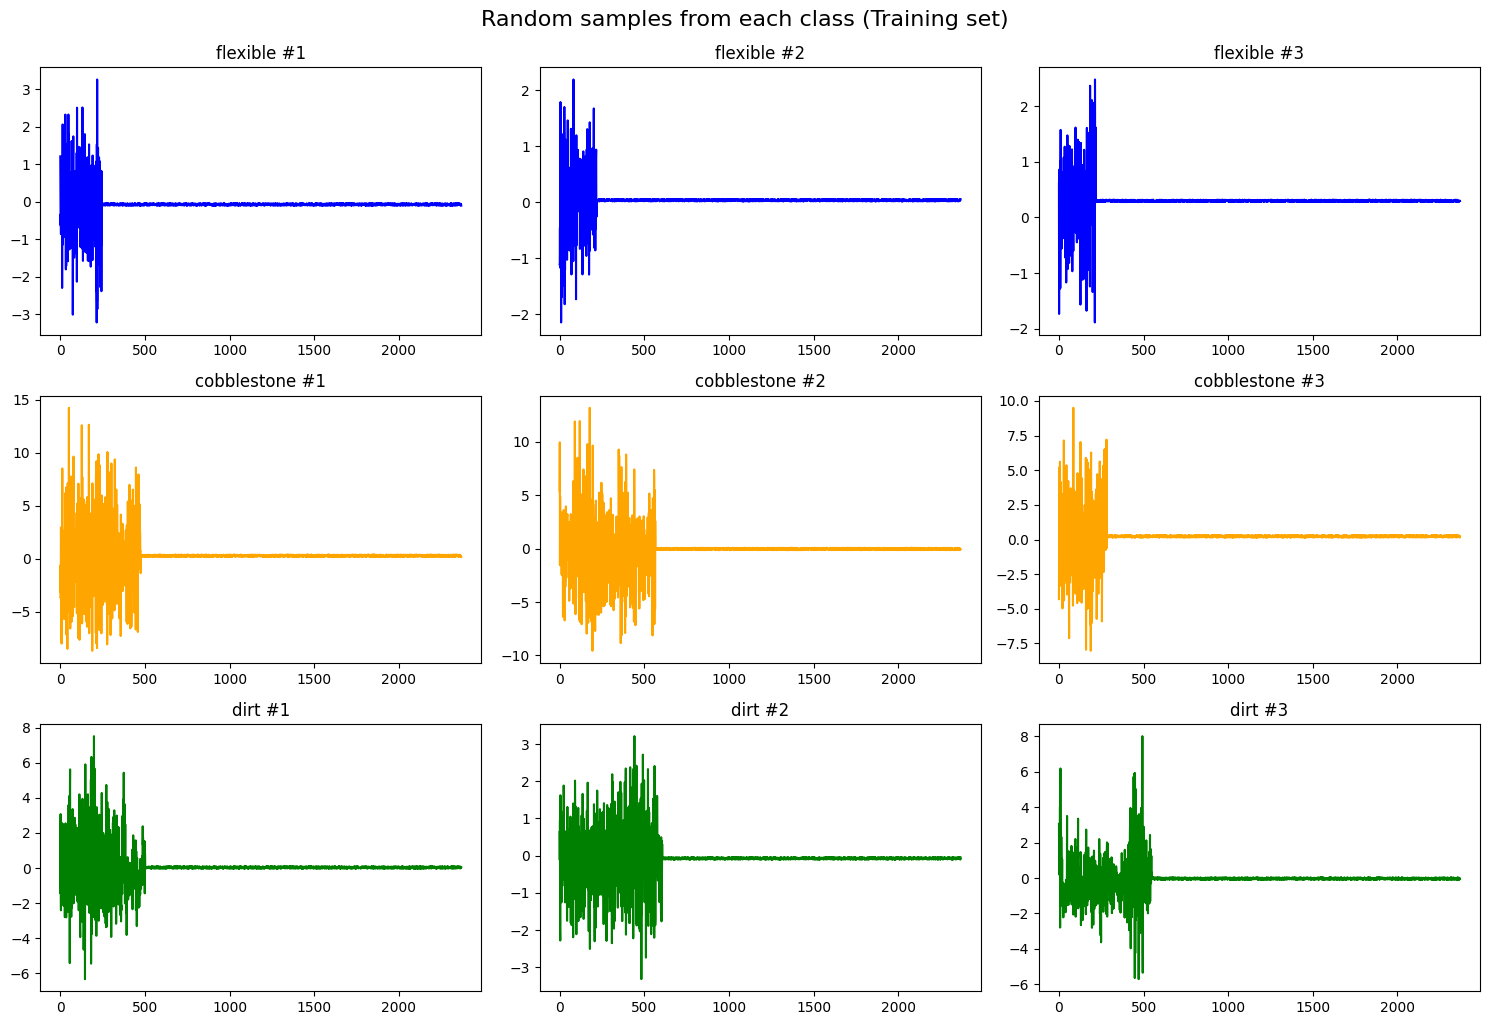

In [13]:
num = 3
train_file = os.path.join('AsphaltPavementType', 'AsphaltPavementType_eq_TRAIN.ts')

X_train_raw, y_train = load_ts_file(train_file)

plt.figure(figsize=(15, 10))

labels = ['flexible', 'cobblestone', 'dirt']
colors = ['blue', 'orange', 'green']

for label in range(3): 
    indices = np.where(y_train == label)[0]
    selected = np.random.choice(indices, size=num, replace=False)
    
    for i, idx in enumerate(selected):
        plt.subplot(3, num, label * num + i + 1)
        plt.plot(X_train_raw[idx], color=colors[label])
        plt.title(f'{labels[label]} #{i+1}')

plt.tight_layout()
plt.suptitle("Random samples from each class (Training set)", fontsize=16, y=1.02)
plt.show()


# Check the shape of the datasets

In [14]:
for (x1, x2), y in train_ds.take(1):
    print("\nDataset shapes:")
    print("Input shape:", x1.shape,"\nFeatures layer:", x2.shape)
    print("Label shape:", y.shape)
    print("Sequence length:", sequence_length)


Dataset shapes:
Input shape: (128, 2370, 1) 
Features layer: (128, 12)
Label shape: (128, 3)
Sequence length: 2370


## NN Evaluation Methods

In [15]:
def evaluate_NN_models(model_list, test_ds, class_names=None):
    all_results = []

    # Get true labels
    y_test = np.concatenate([y for _, y in test_ds], axis=0)
    y_true = np.argmax(y_test, axis=1)

    for model in model_list:
        # Evaluate accuracy and loss
        loss, acc = model.evaluate(test_ds, verbose=0)

        # Predict
        y_pred_probs = model.predict(test_ds)
        y_pred = np.argmax(np.vstack(y_pred_probs), axis=1)

        # Classification report
        report = classification_report(
            y_true,
            y_pred,
            target_names=class_names if class_names else None,
            output_dict=True,
            zero_division=0
        )

        # Confusion matrix
        cm = confusion_matrix(y_true, y_pred)

        result = {
            'model': model,
            'loss': loss,
            'accuracy': acc,
            'y_pred': y_pred,
            'y_true': y_true,
            'report': report,
            'confusion_matrix': cm
        }

        all_results.append(result)

    return all_results


In [16]:
def print_table(data,headers):
    table_data = list(zip(*data))
    table = tabulate(table_data, headers=headers, tablefmt='grid')
    print(table)

In [17]:
def plot_confusion_matrix(ax, cm, class_names, title, cmap):
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    cm_percent = np.round(cm_normalized * 100, 1)

    labels = np.array([["{:.1f}%".format(p) for p in row] for row in cm_percent])

    sns.heatmap(cm_percent, annot=labels, fmt='', cmap=cmap, cbar=True, ax=ax,
                xticklabels=class_names, yticklabels=class_names)
    ax.set_xlabel('Predicted label')
    ax.set_ylabel('True label')
    ax.set_title(title)


In [18]:
def draw_confusion_matrix(matrix, name):
    colormap = ["Blues", "Greens", "Oranges"]
    fig, axes = plt.subplots(1, 1, figsize=(8, 6))  # یک نمودار
    class_names = ['flexible', 'cobblestone', 'dirt']
    plot_confusion_matrix(axes, matrix[0], class_names, "Confusion Matrix (%)", colormap[0])
    plt.tight_layout()
    plt.show()


In [19]:
def plot_confusion_matrix_to_image(cm, class_names):
    fig = plt.figure(figsize=(6, 6))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title("Confusion Matrix")
    plt.colorbar()
    tick_marks = range(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=45)
    plt.yticks(tick_marks, class_names)

    fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

    buf = io.BytesIO()
    plt.savefig(buf, format='png')
    plt.close(fig)
    buf.seek(0)
    image = tf.image.decode_png(buf.getvalue(), channels=4)
    return tf.expand_dims(image, 0)


# Custom callbacks

In [20]:
class ConfusionMatrixCallback(tf.keras.callbacks.Callback):
    def __init__(self, val_data, log_dir, class_names):
        super().__init__()
        self.val_data = val_data
        self.file_writer_cm = tf.summary.create_file_writer(log_dir + '/cm')
        self.class_names = class_names

    def on_epoch_end(self, epoch, logs=None):
        # Predict and compute confusion matrix
        y_true = []
        y_pred = []

        for x_batch, y_batch in self.val_data:
            preds = self.model.predict(x_batch)
            y_true.extend(tf.argmax(y_batch, axis=1).numpy())
            y_pred.extend(tf.argmax(preds, axis=1).numpy())

        cm = confusion_matrix(y_true, y_pred)

        # Log image
        cm_image = plot_confusion_matrix_to_image(cm, self.class_names)
        with self.file_writer_cm.as_default():
            tf.summary.image("Confusion Matrix", cm_image, step=epoch)


In [21]:
class ROCandPRCurveCallback(tf.keras.callbacks.Callback):
    def __init__(self, val_data, log_dir, class_names):
        super().__init__()
        self.val_data = val_data
        self.class_names = class_names
        self.file_writer = tf.summary.create_file_writer(log_dir + '/pr_roc')

    def on_epoch_end(self, epoch, logs=None):
        y_true = []
        y_probs = []

        for x_batch, y_batch in self.val_data:
            y_true.extend(y_batch.numpy())
            y_probs.extend(self.model.predict(x_batch))

        y_true = np.array(y_true)
        y_probs = np.array(y_probs)

        # One-vs-rest curves
        for i, class_name in enumerate(self.class_names):
            true_binary = y_true[:, i]
            prob = y_probs[:, i]

            precision, recall, _ = precision_recall_curve(true_binary, prob)
            fpr, tpr, _ = roc_curve(true_binary, prob)

            with self.file_writer.as_default():
                tf.summary.scalar(f'PR_AUC/{class_name}', np.trapz(precision, recall), step=epoch)
                tf.summary.scalar(f'ROC_AUC/{class_name}', np.trapz(tpr, fpr), step=epoch)


## Hyperparameters Optimization

In [22]:
class HyperModel(kt.HyperModel):
    def __init__(self, sequence_length, num_classes, stats_input_dim=12):
        self.sequence_length = sequence_length
        self.num_classes = num_classes
        self.stats_input_dim = stats_input_dim

    def build(self, hp):
        quant_kwargs = dict(kernel_quantizer=quantized_bits(2, 0, 1))

        # Signal Input Branch
        signal_input = Input(shape=(self.sequence_length, 1), name='signal_input')

        x = Conv1D(filters=hp.Int('conv1_filters', 8, 24, step=8),
                   kernel_size=3,
                   activation='relu')(signal_input)
        x = MaxPooling1D(pool_size=2)(x)
        x = BatchNormalization(scale=False)(x)

        x = QConv1D(filters=hp.Int('qconv1_filters', 4, 12, step=4),
                    kernel_size=3,
                    use_bias=False,
                    **quant_kwargs)(x)
        x = MaxPooling1D(pool_size=2)(x)
        x = BatchNormalization(scale=False)(x)
        x = Dropout(rate=hp.Float('dropout1', 0.3, 0.5))(x)

        x = QConv1D(filters=hp.Int('qconv2_filters', 4, 12, step=4),
                    kernel_size=3,
                    use_bias=False,
                    **quant_kwargs)(x)
        x = MaxPooling1D(pool_size=2)(x)
        x = BatchNormalization(scale=False)(x)
        x = Dropout(rate=hp.Float('dropout2', 0.3, 0.5))(x)

        x = Flatten()(x)

        # Stats Input Branch
        stats_input = Input(shape=(self.stats_input_dim,), name="stats_input")
        s = Dropout(hp.Float('stats_dropout', 0.3, 0.5, step=0.1))(stats_input)

        if hp.Boolean('use_stats_dense'):
            s = Dense(units=hp.Int('stats_dense_units', 8, 12, step=4),
                      activation=hp.Choice('stats_activation', ['relu', 'tanh', 'elu']))(s)
            s = BatchNormalization(scale=False)(s)

        # Merge Branches
        merged = Concatenate()([x, s])
        merged = QDense(units=hp.Int('qdense_units', 4, 16, step=4),
                        use_bias=False,
                        **quant_kwargs)(merged)
        merged = BatchNormalization(scale=False)(merged)
        merged = Dropout(0.4)(merged)

        output = Dense(self.num_classes, activation='softmax')(merged)

        model = Model(inputs=[signal_input, stats_input], outputs=output)

        model.compile(
            optimizer=Adam(hp.Float('learning_rate', 1e-5, 1e-3, sampling='log')),
            loss='categorical_crossentropy',
            metrics=['accuracy']
        )

        return model


# Tuner configuration

In [23]:
# Initialize the hypermodel
hypermodel = HyperModel(sequence_length=sequence_length, num_classes=3)

project_name = f"asphaltpavement_tune_{datetime.now().strftime('%Y%m%d-%H%M%S')}"

# Create the tuner
tuner = kt.BayesianOptimization(
    hypermodel,
    objective='val_accuracy',
    max_trials=trial,
    directory='bayesian_opt',
    project_name=project_name 
)

# Define early stopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=40,
    verbose=1,
    mode='min',
    restore_best_weights=True
)


run_name = f"bnn_model_{datetime.now().strftime('%Y%m%d-%H%M%S')}"
log_dir = os.path.join("logs", "fit", run_name)

tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)
conf_matrix_callback = ConfusionMatrixCallback(val_data=test_ds, log_dir=log_dir, class_names=["flexible", "cobblestone", "dirt"])
pr_roc_callback = ROCandPRCurveCallback(val_data=test_ds, log_dir=log_dir, class_names=["flexible", "cobblestone", "dirt"])

callbacks = [early_stopping, tensorboard_callback, conf_matrix_callback, pr_roc_callback]

simple_callbacks = [early_stopping]

# Search for the best hyperparameters
tuner.search(
    train_ds,
    epochs=epoch,
    batch_size=128,
    validation_data=val_ds,
    callbacks=simple_callbacks
)

# Get the best hyperparameters
best_hps_list = tuner.get_best_hyperparameters(num_trials=3)
best_models_list = tuner.get_best_models(num_models=3)

Trial 200 Complete [00h 02m 57s]
val_accuracy: 0.8355555534362793

Best val_accuracy So Far: 0.9866666793823242
Total elapsed time: 14h 16m 42s


In [24]:
# Show the top 3 models
print("\nTop 3 Models Performance:")
print("-" * 50)

for idx, hps in enumerate(best_hps_list, 1):
    print(f"\nModel {idx}:")
    print("Hyperparameters:")
    for param, value in hps.values.items():
        print(f"{param}: {value}")
    print(f"Validation Accuracy: {best_models_list[idx-1].evaluate(val_ds, verbose=0)[1]:.3f}")
        
# Let user choose the model
while True:
    try:
        choice = int(input("\nChoose a model (1, 2, or 3): "))
        if 1 <= choice <= 3:
            break
        print("Please enter 1, 2, or 3")
    except ValueError:
        print("Please enter a valid number")

# Use the chosen model
model = best_models_list[choice - 1]
chosen_hps = best_hps_list[choice - 1]

print(f"\nSelected Model {choice}")
print("Final hyperparameters:")
for param, value in chosen_hps.values.items():
    print(f"{param}: {value}")


Top 3 Models Performance:
--------------------------------------------------

Model 1:
Hyperparameters:
conv1_filters: 24
qconv1_filters: 12
dropout1: 0.3
qconv2_filters: 12
dropout2: 0.3
stats_dropout: 0.3
use_stats_dense: False
qdense_units: 4
learning_rate: 0.001
stats_dense_units: 8
stats_activation: relu
Validation Accuracy: 0.987

Model 2:
Hyperparameters:
conv1_filters: 24
qconv1_filters: 12
dropout1: 0.3
qconv2_filters: 12
dropout2: 0.5
stats_dropout: 0.5
use_stats_dense: False
qdense_units: 16
learning_rate: 0.001
stats_dense_units: 12
stats_activation: relu
Validation Accuracy: 0.987

Model 3:
Hyperparameters:
conv1_filters: 24
qconv1_filters: 12
dropout1: 0.3
qconv2_filters: 12
dropout2: 0.42395173124092134
stats_dropout: 0.4
use_stats_dense: False
qdense_units: 16
learning_rate: 0.001
stats_dense_units: 12
stats_activation: relu
Validation Accuracy: 0.982

Selected Model 3
Final hyperparameters:
conv1_filters: 24
qconv1_filters: 12
dropout1: 0.3
qconv2_filters: 12
dropout2

## Build BNN

In [25]:
filters_conv1d = filters=chosen_hps.get('conv1_filters')
filters_qconv1d = filters=chosen_hps.get('qconv1_filters')
filters_qconv2d = filters=chosen_hps.get('qconv2_filters')
units_qdense = chosen_hps.get('qdense_units')
learning_rate = 0.00043
dropout1 = chosen_hps.get('dropout1')
dropout2 = chosen_hps.get('dropout2')
stats_dropout = chosen_hps.get('stats_dropout')
use_stats_dense = chosen_hps.get('use_stats_dense')
stats_denseunits = chosen_hps.get('stats_dense_units')
stats_activationfunc = chosen_hps.get('stats_activation')
epochs = 300

from tensorflow.keras.callbacks import TensorBoard
# Define early stopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=40,
    verbose=1,
    mode='min',
    restore_best_weights=True
)

from datetime import datetime

run_name = f"bnn_model_{datetime.now().strftime('%Y%m%d-%H%M%S')}"
log_dir = os.path.join("logs", "fit", run_name)

tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)
conf_matrix_callback = ConfusionMatrixCallback(val_data=test_ds, log_dir=log_dir, class_names=["flexible", "cobblestone", "dirt"])
pr_roc_callback = ROCandPRCurveCallback(val_data=test_ds, log_dir=log_dir, class_names=["flexible", "cobblestone", "dirt"])
# reduce_lr
callbacks = [early_stopping, tensorboard_callback, conf_matrix_callback, pr_roc_callback]
filters_conv1d = 16
filters_qconv1d = 16
filters_qconv2d = 8
units_qdense = 8
learning_rate = 0.0004
dropout1 = 0.4
dropout2 = 0.4
stats_dropout = 0.4
use_stats_dense = True
stats_denseunits = 8
stats_activationfunc = 'tanh'
epochs = 500
batch_size = 128

In [26]:
quant_kwargs = dict(kernel_quantizer=quantized_bits(2, 0, 1))

# Signal Input Branch
signal_input = Input(shape=(sequence_length, 1), name='signal_input')

x = Conv1D(filters=filters_conv1d, kernel_size=5, activation='relu')(signal_input)
x = MaxPooling1D(pool_size=2)(x)
x = BatchNormalization(scale=False)(x)

x = QConv1D(filters=filters_qconv1d, kernel_size=5, use_bias=False, **quant_kwargs)(x)
x = MaxPooling1D(pool_size=2)(x)
x = BatchNormalization(scale=False)(x)
x = Dropout(dropout1)(x)

x = QConv1D(filters=filters_qconv2d, kernel_size=5, use_bias=False, **quant_kwargs)(x)
x = MaxPooling1D(pool_size=2)(x)
x = BatchNormalization(scale=False)(x)
x = Dropout(dropout2)(x)

x = Flatten()(x)

# Statistical Features Branch
stats_input = Input(shape=(12,), name='stats_input')


s = Dropout(stats_dropout)(stats_input)

if use_stats_dense:
    stats_dense_units = stats_denseunits
    stats_activation = stats_activationfunc
    s = Dense(units=stats_dense_units, activation=stats_activation)(s)
    s = BatchNormalization(scale=False)(s)

# Merge Branches
combined = Concatenate()([x, s])

# Dense Layers after merging
combined = QDense(units=units_qdense, use_bias=False, **quant_kwargs)(combined)
combined = BatchNormalization(scale=False)(combined)
combined = Dropout(0.4)(combined)  
#combined = Dense(units=16, activation='relu')(combined)  # Extra dense layer
combined = BatchNormalization(scale=False)(combined)

# Output Layer
output = Dense(3, activation='softmax')(combined)

# Final Model
model = Model(inputs=[signal_input, stats_input], outputs=output)

# Compile the model

In [27]:
model.compile(optimizer=Adam(learning_rate=learning_rate), loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 signal_input (InputLayer)      [(None, 2370, 1)]    0           []                               
                                                                                                  
 conv1d_1 (Conv1D)              (None, 2366, 24)     144         ['signal_input[0][0]']           
                                                                                                  
 max_pooling1d_3 (MaxPooling1D)  (None, 1183, 24)    0           ['conv1d_1[0][0]']               
                                                                                                  
 batch_normalization_4 (BatchNo  (None, 1183, 24)    72          ['max_pooling1d_3[0][0]']        
 rmalization)                                                                               

# Training the Model

File AsphaltPavementType/AsphaltPavementType_eq_TRAIN.ts:
Number of samples: 1055
Unique labels: [0 1 2]
Label distribution: [408 263 384]

New train distribution: [500 500 500]


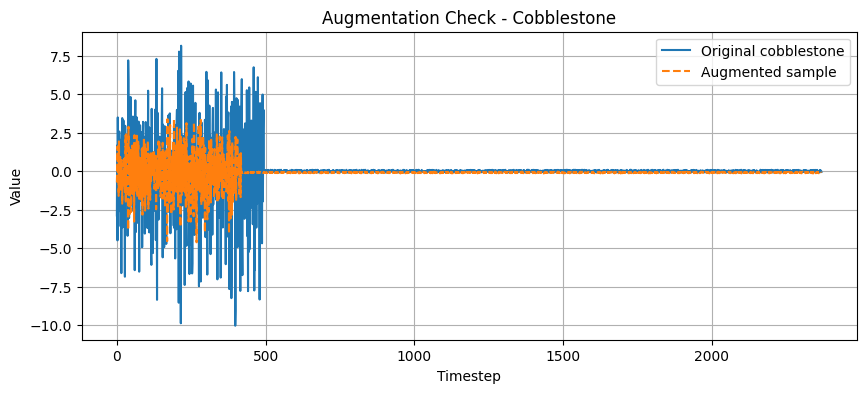

File AsphaltPavementType/AsphaltPavementType_eq_TEST.ts:
Number of samples: 1056
Unique labels: [0 1 2]
Label distribution: [408 264 384]

Training samples: 1500
Test samples: 1056
Unique classes in training: [0 1 2]
Class distribution in training: [500 500 500]
Epoch 1/500
10/10 [==============================] - 14s 999ms/step - loss: 1.0970 - accuracy: 0.5349 - val_loss: 1.0760 - val_accuracy: 0.4800
Epoch 2/500
10/10 [==============================] - 8s 859ms/step - loss: 0.7587 - accuracy: 0.6392 - val_loss: 0.7663 - val_accuracy: 0.6622
Epoch 3/500
10/10 [==============================] - 7s 801ms/step - loss: 0.7106 - accuracy: 0.6612 - val_loss: 0.6555 - val_accuracy: 0.6800
Epoch 4/500
10/10 [==============================] - 7s 775ms/step - loss: 0.6563 - accuracy: 0.7082 - val_loss: 0.5781 - val_accuracy: 0.7689
Epoch 5/500
10/10 [==============================] - 7s 735ms/step - loss: 0.6561 - accuracy: 0.6949 - val_loss: 0.6051 - val_accuracy: 0.7422
Epoch 6/500
10/10 [==

In [28]:
from sklearn.utils import class_weight

# Get raw labels from loader (initialize it again)
loader = AsphaltDataLoader(seed=42)
loader.load_dataset(batch_size=128)  # Run to populate y_train_raw


history = model.fit(
    train_ds,
    epochs=500,
    batch_size=128,
    validation_data=val_ds,
    callbacks=callbacks,
    verbose=1
)


### Evaluate

In [29]:
results = evaluate_NN_models([model], test_ds, class_names=["flexible", "cobblestone", "dirt"])


9/9 [==============================] - 1s 37ms/step


In [30]:
def print_full_report(report, model_name="Model"):
    headers = ["Class", "Precision", "Recall", "F1-score"]
    rows = []

    for cls, metrics in report.items():
        if cls in ['accuracy', 'macro avg', 'weighted avg']:
            continue
        rows.append([
            cls,
            f"{metrics['precision']:.4f}",
            f"{metrics['recall']:.4f}",
            f"{metrics['f1-score']:.4f}"
        ])

    # Add macro avg & weighted avg
    macro = report['macro avg']
    weighted = report['weighted avg']
    rows.append(["Macro Avg", f"{macro['precision']:.4f}", f"{macro['recall']:.4f}", f"{macro['f1-score']:.4f}", "-"])
    rows.append(["Weighted Avg", f"{weighted['precision']:.4f}", f"{weighted['recall']:.4f}", f"{weighted['f1-score']:.4f}", "-"])

    print(f"\n=== {model_name} Classification Report ===")
    print(tabulate(rows, headers=headers, tablefmt="grid"))
    print(f"\nOverall Accuracy: {report['accuracy']:.4f}")

# Define class labels
class_names = ["flexible", "cobblestone", "dirt"]

# Run evaluation
results = evaluate_NN_models([model], test_ds, class_names=class_names)

# Print table
print_full_report(results[0]['report'], model_name="BNN Model")


9/9 [==============================] - 0s 38ms/step

=== BNN Model Classification Report ===
+--------------+-------------+----------+------------+
| Class        |   Precision |   Recall |   F1-score |
+==============+=============+==========+============+
| flexible     |      0.9597 |   0.9926 |     0.9759 |
+--------------+-------------+----------+------------+
| cobblestone  |      0.8711 |   0.7424 |     0.8016 |
+--------------+-------------+----------+------------+
| dirt         |      0.8337 |   0.888  |     0.86   |
+--------------+-------------+----------+------------+
| Macro Avg    |      0.8882 |   0.8744 |     0.8792 |
+--------------+-------------+----------+------------+
| Weighted Avg |      0.8918 |   0.892  |     0.8902 |
+--------------+-------------+----------+------------+

Overall Accuracy: 0.8920


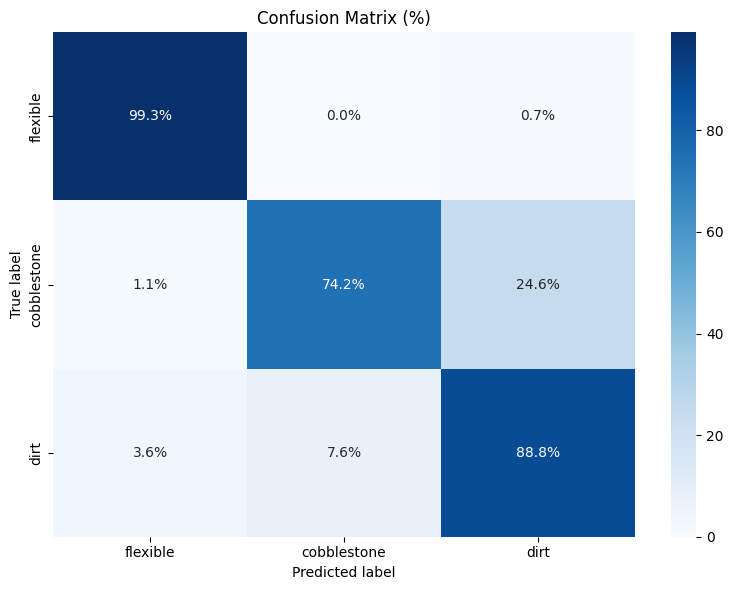

In [31]:
draw_confusion_matrix([results[0]['confusion_matrix']], "Confusion Matrix")

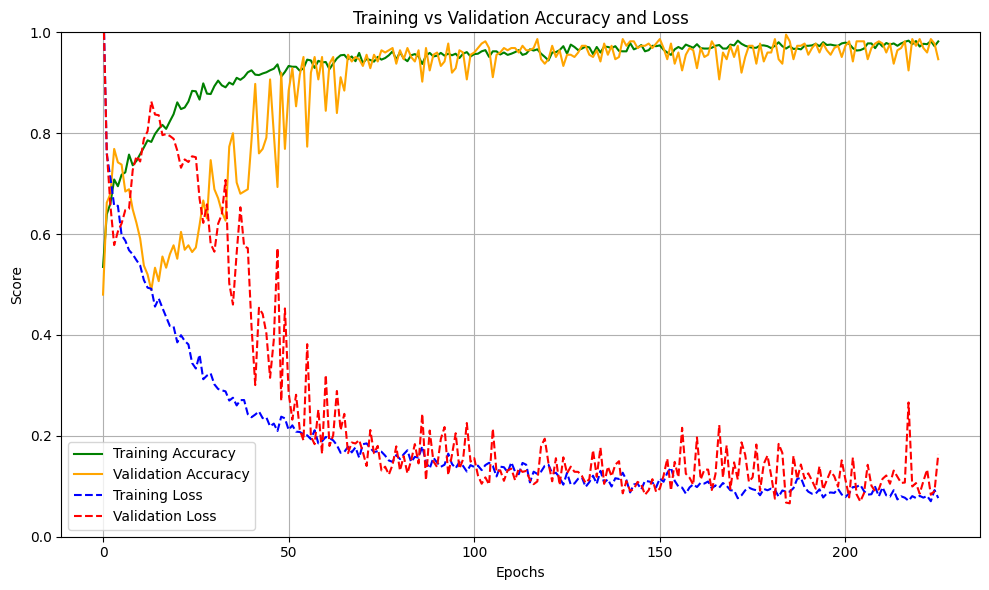

In [32]:
plt.figure(figsize=(10, 6))

# Accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy', color='green')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='orange')

# Loss
plt.plot(history.history['loss'], label='Training Loss', color='blue', linestyle='--')
plt.plot(history.history['val_loss'], label='Validation Loss', color='red', linestyle='--')

plt.xlabel("Epochs")
plt.ylabel("Score")
plt.title("Training vs Validation Accuracy and Loss")
plt.ylim(0, 1)  # Keep all values in the same visual range
plt.legend(loc='lower left')
plt.grid(True)
plt.tight_layout()
plt.show()


9/9 [==============================] - 0s 38ms/step


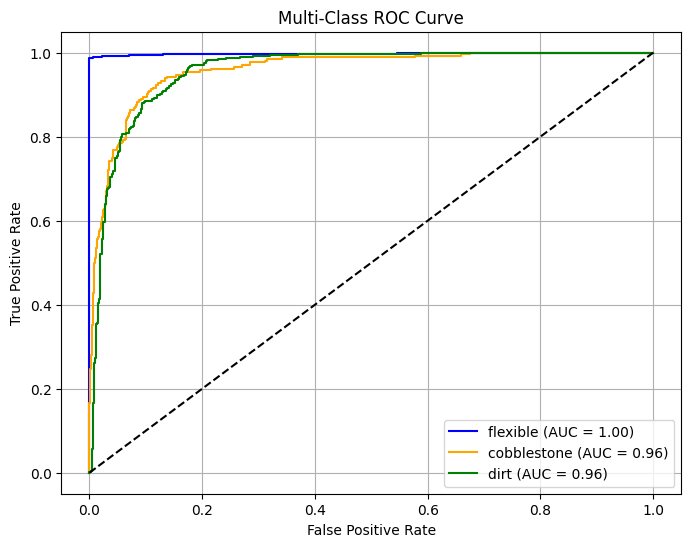

In [33]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt

# y_true = class indices
y_true = results[0]['y_true']
# y_scores = softmax output
y_scores = np.vstack(model.predict(test_ds))

# Binarize labels
y_bin = label_binarize(y_true, classes=[0, 1, 2])

fpr = {}
tpr = {}
roc_auc = {}

for i in range(3):  # for each class
    fpr[i], tpr[i], _ = roc_curve(y_bin[:, i], y_scores[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot
plt.figure(figsize=(8, 6))
colors = ['blue', 'orange', 'green']
class_names = ['flexible', 'cobblestone', 'dirt']
for i in range(3):
    plt.plot(fpr[i], tpr[i], color=colors[i], label=f"{class_names[i]} (AUC = {roc_auc[i]:.2f})")

plt.plot([0, 1], [0, 1], 'k--')
plt.title("Multi-Class ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid(True)
plt.show()


In [34]:
# Model Save
model.save("AsphaltRegularity/asphalt_bnn_final_model.h5")
model_json = model.to_json()
with open("AsphaltRegularity/asphalt_bnn_model.json", "w") as json_file:
    json_file.write(model_json)

model.save_weights("AsphaltRegularity/asphalt_bnn_weights.h5")


# K fold cross validation

In [ ]:
# Reuse the DataLoader to get the full dataset
loader = AsphaltDataLoader(seed=42)
train_file = os.path.join(loader.data_dir, 'AsphaltPavementType_eq_TRAIN.ts')
X_raw, y_raw = load_ts_file(train_file)

# Augment to balance classes
X_raw, y_raw = augment_classes(X_raw, y_raw)
print("After augmentation class distribution:", np.bincount(y_raw))

# Extract statistical features
features = extract_features(X_raw)

# Normalize signals and features
X_total = loader.scaler.fit_transform(X_raw)
features_total = loader.feature_scaler.fit_transform(features)

# Reshape signal input
X_total = X_total.reshape(-1, X_total.shape[1], 1)

# One-hot encode labels
y_total = to_categorical(y_raw, num_classes=3)


File AsphaltPavementType/AsphaltPavementType_eq_TRAIN.ts:
Number of samples: 1055
Unique labels: [0 1 2]
Label distribution: [408 263 384]



In [40]:
def model_builder():
    quant_kwargs = dict(kernel_quantizer=quantized_bits(2, 0, 1))

    signal_input = Input(shape=(sequence_length, 1), name='signal_input')
    x = Conv1D(filters=filters_conv1d, kernel_size=5, activation='relu')(signal_input)
    x = MaxPooling1D(pool_size=2)(x)
    x = BatchNormalization(scale=False)(x)
    x = QConv1D(filters=filters_qconv1d, kernel_size=5, use_bias=False, **quant_kwargs)(x)
    x = MaxPooling1D(pool_size=2)(x)
    x = BatchNormalization(scale=False)(x)
    x = Dropout(dropout1)(x)
    x = QConv1D(filters=filters_qconv2d, kernel_size=5, use_bias=False, **quant_kwargs)(x)
    x = MaxPooling1D(pool_size=2)(x)
    x = BatchNormalization(scale=False)(x)
    x = Dropout(dropout2)(x)
    x = Flatten()(x)

    stats_input = Input(shape=(12,), name='stats_input')
    s = Dropout(stats_dropout)(stats_input)
    if use_stats_dense:
        s = Dense(units=stats_denseunits, activation=stats_activationfunc)(s)
        s = BatchNormalization(scale=False)(s)

    combined = Concatenate()([x, s])
    combined = QDense(units=units_qdense, use_bias=False, **quant_kwargs)(combined)
    combined = BatchNormalization(scale=False)(combined)
    combined = Dropout(0.4)(combined)
    combined = BatchNormalization(scale=False)(combined)

    output = Dense(3, activation='softmax')(combined)

    model = Model(inputs=[signal_input, stats_input], outputs=output)
    model.compile(optimizer=Adam(learning_rate=learning_rate),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

In [ ]:
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, classification_report
from tabulate import tabulate
import numpy as np
import pandas as pd

def cross_validate_model(model_builder, X_total, features_total, y_total, n_splits=5, batch_size=128, epochs=100):
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    cv_results = []

    for fold, (train_idx, val_idx) in enumerate(kf.split(X_total)):
        print(f"\n--- Fold {fold+1} ---")
        x_train, x_val = X_total[train_idx], X_total[val_idx]
        f_train, f_val = features_total[train_idx], features_total[val_idx]
        y_train, y_val = y_total[train_idx], y_total[val_idx]

        model = model_builder()

        model.fit(
            [x_train, f_train],
            y_train,
            validation_data=([x_val, f_val], y_val),
            epochs=epochs,
            batch_size=batch_size,
            verbose=1
        )

        y_pred = model.predict([x_val, f_val])
        y_pred_labels = np.argmax(y_pred, axis=1)
        y_true_labels = np.argmax(y_val, axis=1)

        acc = accuracy_score(y_true_labels, y_pred_labels)
        report = classification_report(y_true_labels, y_pred_labels, output_dict=True, zero_division=0)

        precision = report['weighted avg']['precision']
        recall = report['weighted avg']['recall']
        f1 = report['weighted avg']['f1-score']

        cv_results.append({
            'Fold': f'Fold {fold+1}',
            'Accuracy': acc,
            'Precision': precision,
            'Recall': recall,
            'F1-Score': f1
        })

    # Compute averages
    df = pd.DataFrame(cv_results)
    mean_row = {
        'Fold': 'Average',
        'Accuracy': df['Accuracy'].mean(),
        'Precision': df['Precision'].mean(),
        'Recall': df['Recall'].mean(),
        'F1-Score': df['F1-Score'].mean()
    }
    df = pd.concat([df, pd.DataFrame([mean_row])], ignore_index=True)

    # Print table
    print("\n=== Cross-Validation Performance Summary ===")
    print(tabulate(df, headers='keys', tablefmt='grid', showindex=False))

    return df


In [42]:
cv_df = cross_validate_model( model_builder,
    X_total,
    features_total,
    y_total,
    n_splits=5,
    batch_size=128,
    epochs=100
)


--- Fold 1 ---
10/10 [==============================] - 3s 28ms/step

--- Fold 2 ---
10/10 [==============================] - 2s 24ms/step

--- Fold 3 ---
10/10 [==============================] - 15s 37ms/step

--- Fold 4 ---
10/10 [==============================] - 2s 26ms/step

--- Fold 5 ---
10/10 [==============================] - 2s 17ms/step

=== Cross-Validation Performance Summary ===
+---------+------------+-------------+----------+------------+
| Fold    |   Accuracy |   Precision |   Recall |   F1-Score |
+=========+============+=============+==========+============+
| Fold 1  |   0.87     |    0.901596 | 0.87     |   0.867585 |
+---------+------------+-------------+----------+------------+
| Fold 2  |   0.946667 |    0.947416 | 0.946667 |   0.94656  |
+---------+------------+-------------+----------+------------+
| Fold 3  |   0.94     |    0.940426 | 0.94     |   0.939887 |
+---------+------------+-------------+----------+------------+
| Fold 4  |   0.923333 |    0.923845